0 1.0023940583557942 0.0 0.002599263649212187


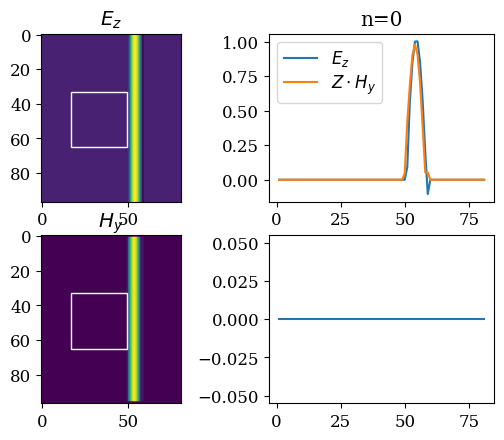

20 1.3293056479938006 0.004346880056160989 0.0032061716125237577


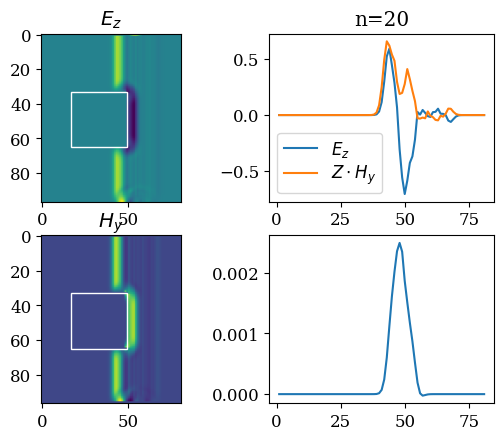

40 1.2580290382061061 0.001626182913276053 0.0030467880902045603


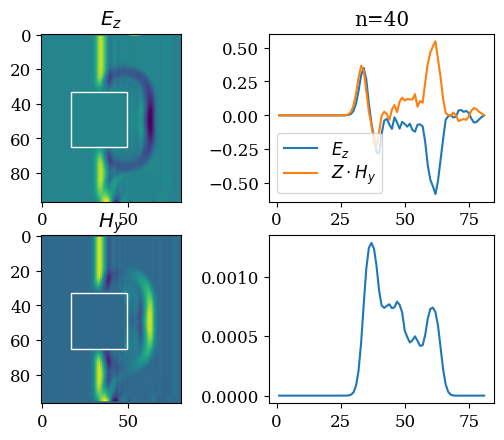

60 1.168880590351075 0.001247105076668576 0.002880596190635013


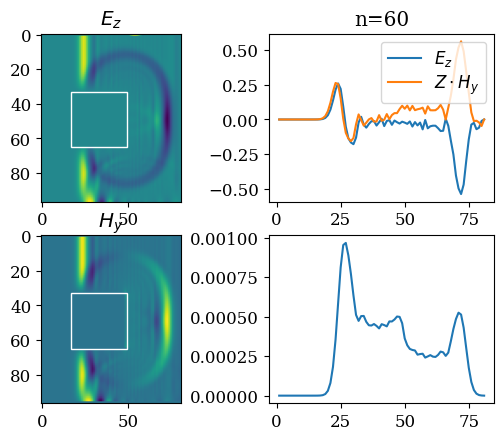

80 1.2048897123500708 0.0010694487774300834 0.0027363533230766925


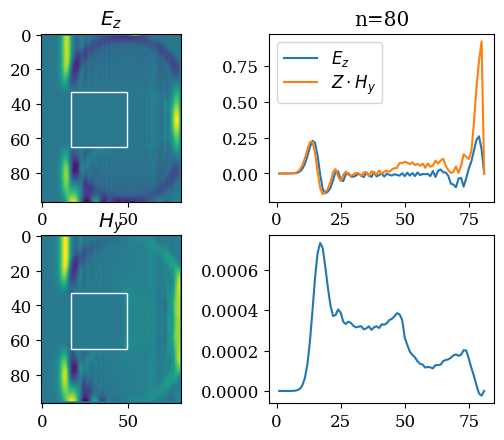

100 1.0802988955652513 0.0010345665437022722 0.002694167936299125


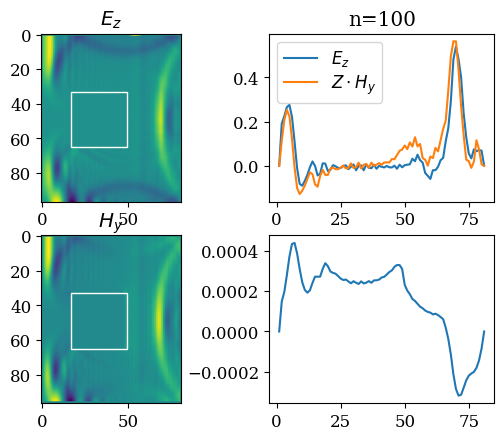

120 1.6070083592311566 0.001720654826228434 0.004244280000434247


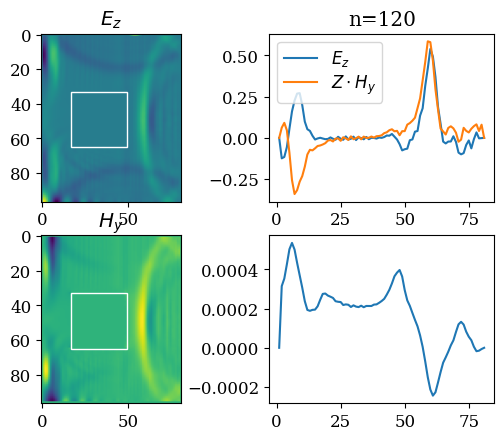

140 1.7952852881298607 0.0020982762427289615 0.0038612213959064853


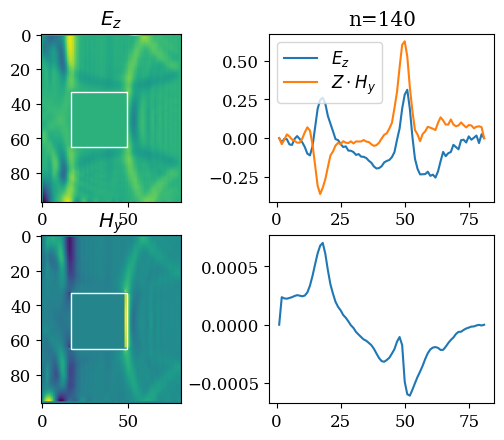

160 1.4977436958552022 0.0013127947581892737 0.0025958343723676983


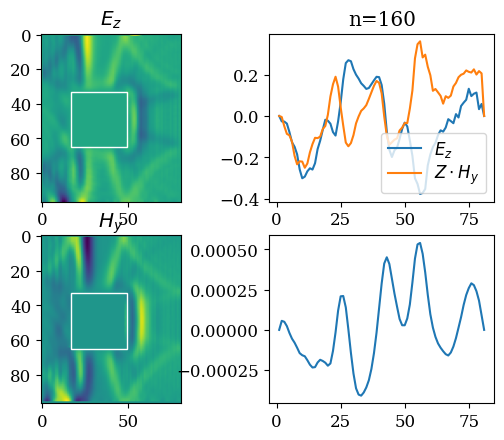

180 1.4568844667565144 0.000948743218213007 0.0024559601078019523


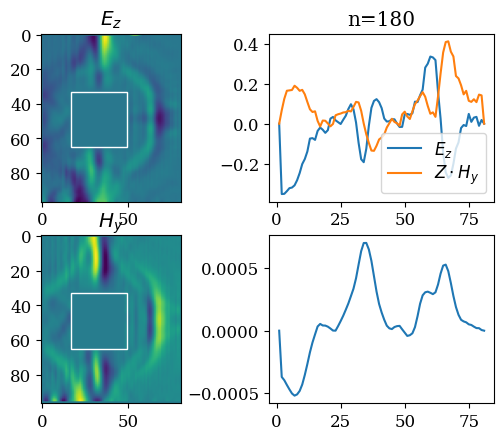

200 1.0247997306112016 0.00210673477405121 0.0029579199046998175


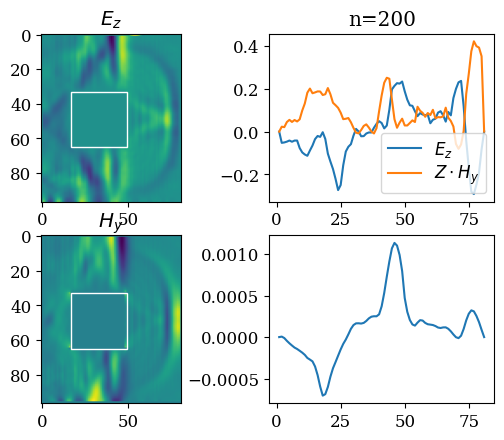

220 1.1082311167691479 0.0016831704326421117 0.0027172470954259253


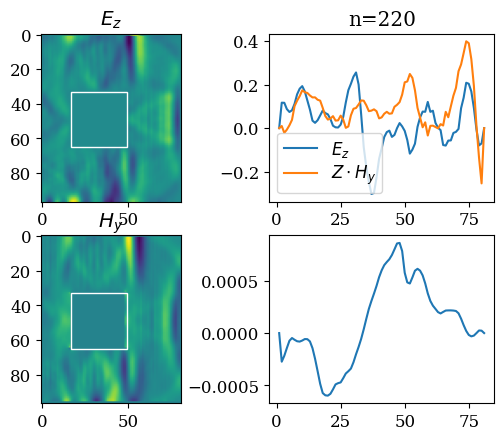

240 1.0358227586538258 0.0010837465285582772 0.0029808320987538923


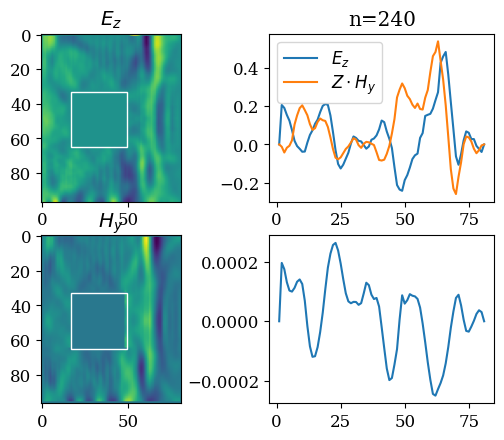

260 1.1319929222293108 0.0010501077798902264 0.002894288987951858


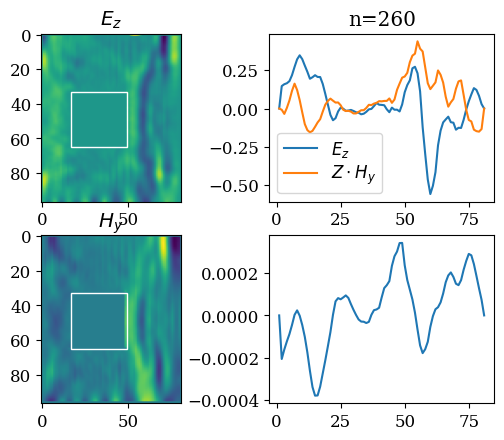

280 1.0023940583557942 0.0010142057657408943 0.005942526643143324


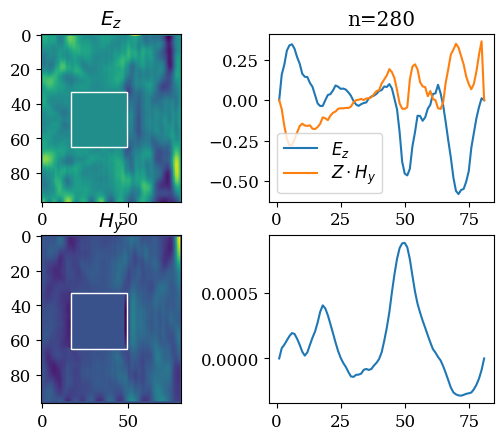

In [20]:
import copy
import numpy as np
from math import * 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rc('font', family='serif')
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'legend.labelspacing':0.25, 'legend.fontsize': 12})


####################################################
## Here I reproduce the original work by Yee 1966 ##
## written on 22/09/2018 by Dr. Andrei P. Igoshev ##
## ignotur@gmail.com                  ##
####################################################

def get_xy_Ez_grid (i,j,n):    ## Basic grid
    x = alpha / 8.0  * i
    y = alpha / 8.0  * j
    t = alpha / 16.0 * n
    return [x,y,t]

def get_xy_Hx_grid (i,j,n):    ## Grid shifted in y direction: i, j+1/2, n-1/2
    x = alpha / 8.0  * i
    y = alpha / 8.0  * (j + 0.5)
    t = alpha / 16.0 * (n - 0.5)
    return [x,y,t]

def get_xy_Hy_grid (i,j,n):    ## Grid shifted in x direction: i+1/2, j, n-1/2
    x = alpha / 8.0  * (i + 0.5)
    y = alpha / 8.0  * j
    t = alpha / 16.0 * (n - 0.5)
    return [x,y,t]

def init_cond (Nx, Ny, alpha, Z):

    Ez = np.zeros ((Nx,Ny)) ## Basic grid i,j 
    Hx = np.zeros ((Nx,Ny)) ## Grid shifted in y direction: i, j-1/2
    Hy = np.zeros ((Nx,Ny)) ## Grid shifted in x direction: i-1/2, j

    for i in range (2, Nx-2):
        for j in range (0, Ny):

            x, y, t = get_xy_Ez_grid (i,j, 0)
            x_hy_grid, y_hy_grid, t_hy_grid = get_xy_Hy_grid (i,j, 0)            
            

            if (8.0 * x - 50.0 * alpha + 16*t > 0 and 8.0 * x  - 50.0 * alpha + 16*t   < 8 * alpha):
                Ez [i,j] =  sin(( 8 * x - 50.0 * alpha + t) / 8.0 / alpha * pi)            ## Actual physical wave, Ez component
            if (8.0 * x_hy_grid - 50.0 * alpha + t_hy_grid > 0 and 8.0 * x_hy_grid  - 50.0 * alpha + t_hy_grid   < 8 * alpha):
                Hy [i,j] =  sin(( 8 * x_hy_grid - 50.0 * alpha + t_hy_grid) / 8.0 / alpha * pi) / Z     ## Actual physical wave
                ## solution of the Maxwell equation in an empty space

    Ez_cut = np.transpose(Ez)[30]
    Hy_cut = np.transpose(Hy)[30]

    i_ind = np.linspace(1, Nx, Nx)

    return [Ez, Hx, Hy]    

def next_time_step (Nx, Ny, alpha, Z, Ez, Hx, Hy):  ## n --> n+1

    Ez_new = np.zeros ((Nx,Ny))
    Hx_new = np.zeros ((Nx,Ny))
    Hy_new = np.zeros ((Nx,Ny))

    for i in range (1, Nx-1):        ## Main bulk, first half step of the leap-frog
        for j in range (0, Ny):    ##

            Ez_new [i,j] = Ez [i,j] - 0.5 * Z * (Hx[i,j] - Hx[i,j-1]) + 0.5 * Z * (Hy[i,j] - Hy[i-1,j]) ## n+1, e.g. n=0, use Hx from n=1/2 step which we have just computed.

            Ez [i,j] = Ez [i,j] - 0.5 * Z * (Hx[i,j] - Hx[i,j-1]) + 0.5 * Z * (Hy[i,j] - Hy[i-1,j]) ## n+1, e.g. n=0, use Hx from n=1/2 step which we have just computed.


    Ez[17:49, 33:65] = 0        ## perfectly conducting square 
    Ez_new[17:49, 33:65] = 0
    
    
    for i in range (1, Nx-1):        ## Main bulk ## next half step of the leap-frog
        for j in range (1, Ny-1):    ##

            Hx_new [i,j] = Hx [i,j] - 0.5 / Z * (Ez[i,j+1] - Ez[i,j])  ## n+1/2 e.g n=0, we use Ez from n=0 step i.e. initial cpndition        
            Hx [i,j] = Hx [i,j] - 0.5 / Z * (Ez[i,j+1] - Ez[i,j]) 
 

    Hx[49,33:65]=0         ## perfectly conducting square
    Hx_new[49,33:65]=0

    Hx[17,33:65]=0         ## perfectly conducting square
    Hx_new[17,33:65]=0


    for i in range (1, Nx-1):        ## Main bulk ## same half step of the leap-frog
        for j in range (1, Ny-1):    ##

            Hy_new [i,j] = Hy [i,j] + 0.5 / Z * (Ez[i+1,j] - Ez[i,j])  ## n+1/2

            Hy [i,j] = Hy [i,j] + 0.5 / Z * (Ez[i+1,j] - Ez[i,j])  ## n+1/2


    Hy[17:49, 33] = 0    ## perfectly conducting square
    Hy[17:49, 65] = 0
    Hy_new[17:49, 33] = 0
    Hy_new[17:49, 65] = 0



    Ez_new[0,:]   = 0     ## Additionally impose the boundary conditions
    Ez_new[Nx-1, :] = 0

    Hx_new[0,:]  = 0 
    Hx_new[Nx-1,:] = 0

    Hx_new[:, 0] = 0
    Hx_new[:, Ny-1] = 0

    return [Ez_new, Hx_new, Hy_new]


Nx = 81
Ny = 97
alpha = 8
Z = 376.7

Ez_init, Hx_init, Hy_init = init_cond (Nx, Ny, alpha, Z) ## Initial conditions

Ez_show = np.transpose(Ez_init)

i_ind = np.linspace(1, Nx, Nx)
j_ind = np.linspace(1, Ny, Ny)

## Get the next timestep and save it to a pdf file, these pdfs can be converted to a movie
for i in range (0, 300):
    Ez1, Hx1, Hy1 = next_time_step (Nx, Ny, alpha, Z, Ez_init, Hx_init, Hy_init)

    Ez_init = copy.copy(Ez1)
    Hx_init = copy.copy(Hx1)
    Hy_init = copy.copy(Hy1)

    if i % 20 != 0: continue

    print(i, np.max(np.fabs(Ez_init)), np.max(np.fabs(Hx_init)), np.max(np.fabs(Hy_init)))

    Ez_show = np.transpose(Ez1)
    Hy_show = np.transpose(Hy1)
    Hx_show = np.transpose(Hx1)
    Ez_cut = Ez_show[30]
    Hy_cut = Hy_show[30]
    Hx_cut = Hx_show[30]
    
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    
    ax1.title.set_text(r'$E_z$')
    ax1.imshow(Ez_show)

    rect = patches.Rectangle((17,33),32,32,linewidth=1,edgecolor='w',facecolor='none')
    ax1.add_patch(rect)
    
    ax2 = fig.add_subplot(222)
    

    ax2.plot(i_ind, Ez_cut, label=r'$E_z$')
    ax2.plot(i_ind, Hy_cut*Z, label=r'$Z\cdot H_y$')
    ax2.legend()
    ax2.title.set_text('n='+str(i))


    rect1 = patches.Rectangle((17,33),32,32,linewidth=1,edgecolor='w',facecolor='none')

    ax3 = fig.add_subplot(223)

    ax3.title.set_text(r'$H_y$')
    ax3.imshow(Hy_show)



    ax3.add_patch(rect1)
    ax4 = fig.add_subplot(224)
    ax4.plot(i_ind, Hx_cut, label=r'$Hx$')
    plt.show()
    plt.close()